<a href="https://colab.research.google.com/github/Mnikito/4016/blob/main/HW2/HW2_Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import numpy as np 
import pandas as pd 

import torch
import torch.optim as optim
import torch.nn as nn

torch.set_printoptions(edgeitems=2, linewidth=75)
 
# Data Visualisation 
import matplotlib.pyplot as plt  
import seaborn as sns

In [ ]:
#Reading training data

housing = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/4106/HW1/Housing.csv"))

In [ ]:
varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
 
# Defining the map function 
def binary_map(x): 
    return x.map({'yes': 1, "no": 0}) 
 
# Applying the function to the housing list 
housing[varlist] = housing[varlist].apply(binary_map) 

In [ ]:
import warnings 
warnings.filterwarnings('ignore') 
#Using this for the plot at the end

num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking'] 
t_u = housing[num_vars]
t_u = torch.FloatTensor(t_u.values)
t_price = torch.FloatTensor(housing['price'])
t_price = torch.tensor(t_price).unsqueeze(1)

from sklearn.preprocessing import MinMaxScaler, StandardScaler 

scaler = MinMaxScaler() 
t_u_n = torch.FloatTensor(scaler.fit_transform(t_u))


t_price_n = torch.FloatTensor(MinMaxScaler().fit_transform(t_price))

In [ ]:
#Splitting the Data into Training and Testing Sets 
from sklearn.model_selection import train_test_split 


df_train, df_test = train_test_split(housing, train_size = 0.8, test_size = 0.2, random_state=7)

In [ ]:
#Filtering out unneeded Yes and No variables

num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price'] 
df_Newtrain = df_train[num_vars] 
df_Newtest = df_test[num_vars] 

In [ ]:
y_train = df_Newtrain.pop('price') 
x_train = df_Newtrain 
y_valid = df_Newtest.pop('price') 
x_valid = df_Newtest

y_train = torch.FloatTensor(y_train)
y_valid = torch.FloatTensor(np.array(y_valid))

y_train = torch.tensor(y_train).unsqueeze(1)
y_valid = torch.tensor(y_valid).unsqueeze(1)

# define standard scaler 
#scaler = StandardScaler() 
scaler = MinMaxScaler() 
Y_NormTrain = torch.FloatTensor(scaler.fit_transform(y_train))
X_NormTrain = torch.FloatTensor(scaler.fit_transform(df_Newtrain))
Y_NormValid = torch.FloatTensor(scaler.fit_transform(y_valid))
X_NormValid = torch.FloatTensor(scaler.fit_transform(df_Newtest))

In [ ]:
from collections import OrderedDict

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 20 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [ ]:
# Model and Training HERE

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(5, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=2e-1)

training_loop(
    n_epochs = 200, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = X_NormTrain,
    t_u_val = X_NormValid, 
    t_c_train = Y_NormTrain,
    t_c_val = Y_NormValid)

Epoch 1, Training loss 0.6013, Validation loss 0.5739
Epoch 20, Training loss 0.0172, Validation loss 0.0179
Epoch 40, Training loss 0.0154, Validation loss 0.0162
Epoch 60, Training loss 0.0142, Validation loss 0.0151
Epoch 80, Training loss 0.0133, Validation loss 0.0145
Epoch 100, Training loss 0.0127, Validation loss 0.0143
Epoch 120, Training loss 0.0123, Validation loss 0.0141
Epoch 140, Training loss 0.0120, Validation loss 0.0142
Epoch 160, Training loss 0.0118, Validation loss 0.0142
Epoch 180, Training loss 0.0116, Validation loss 0.0144
Epoch 200, Training loss 0.0116, Validation loss 0.0145


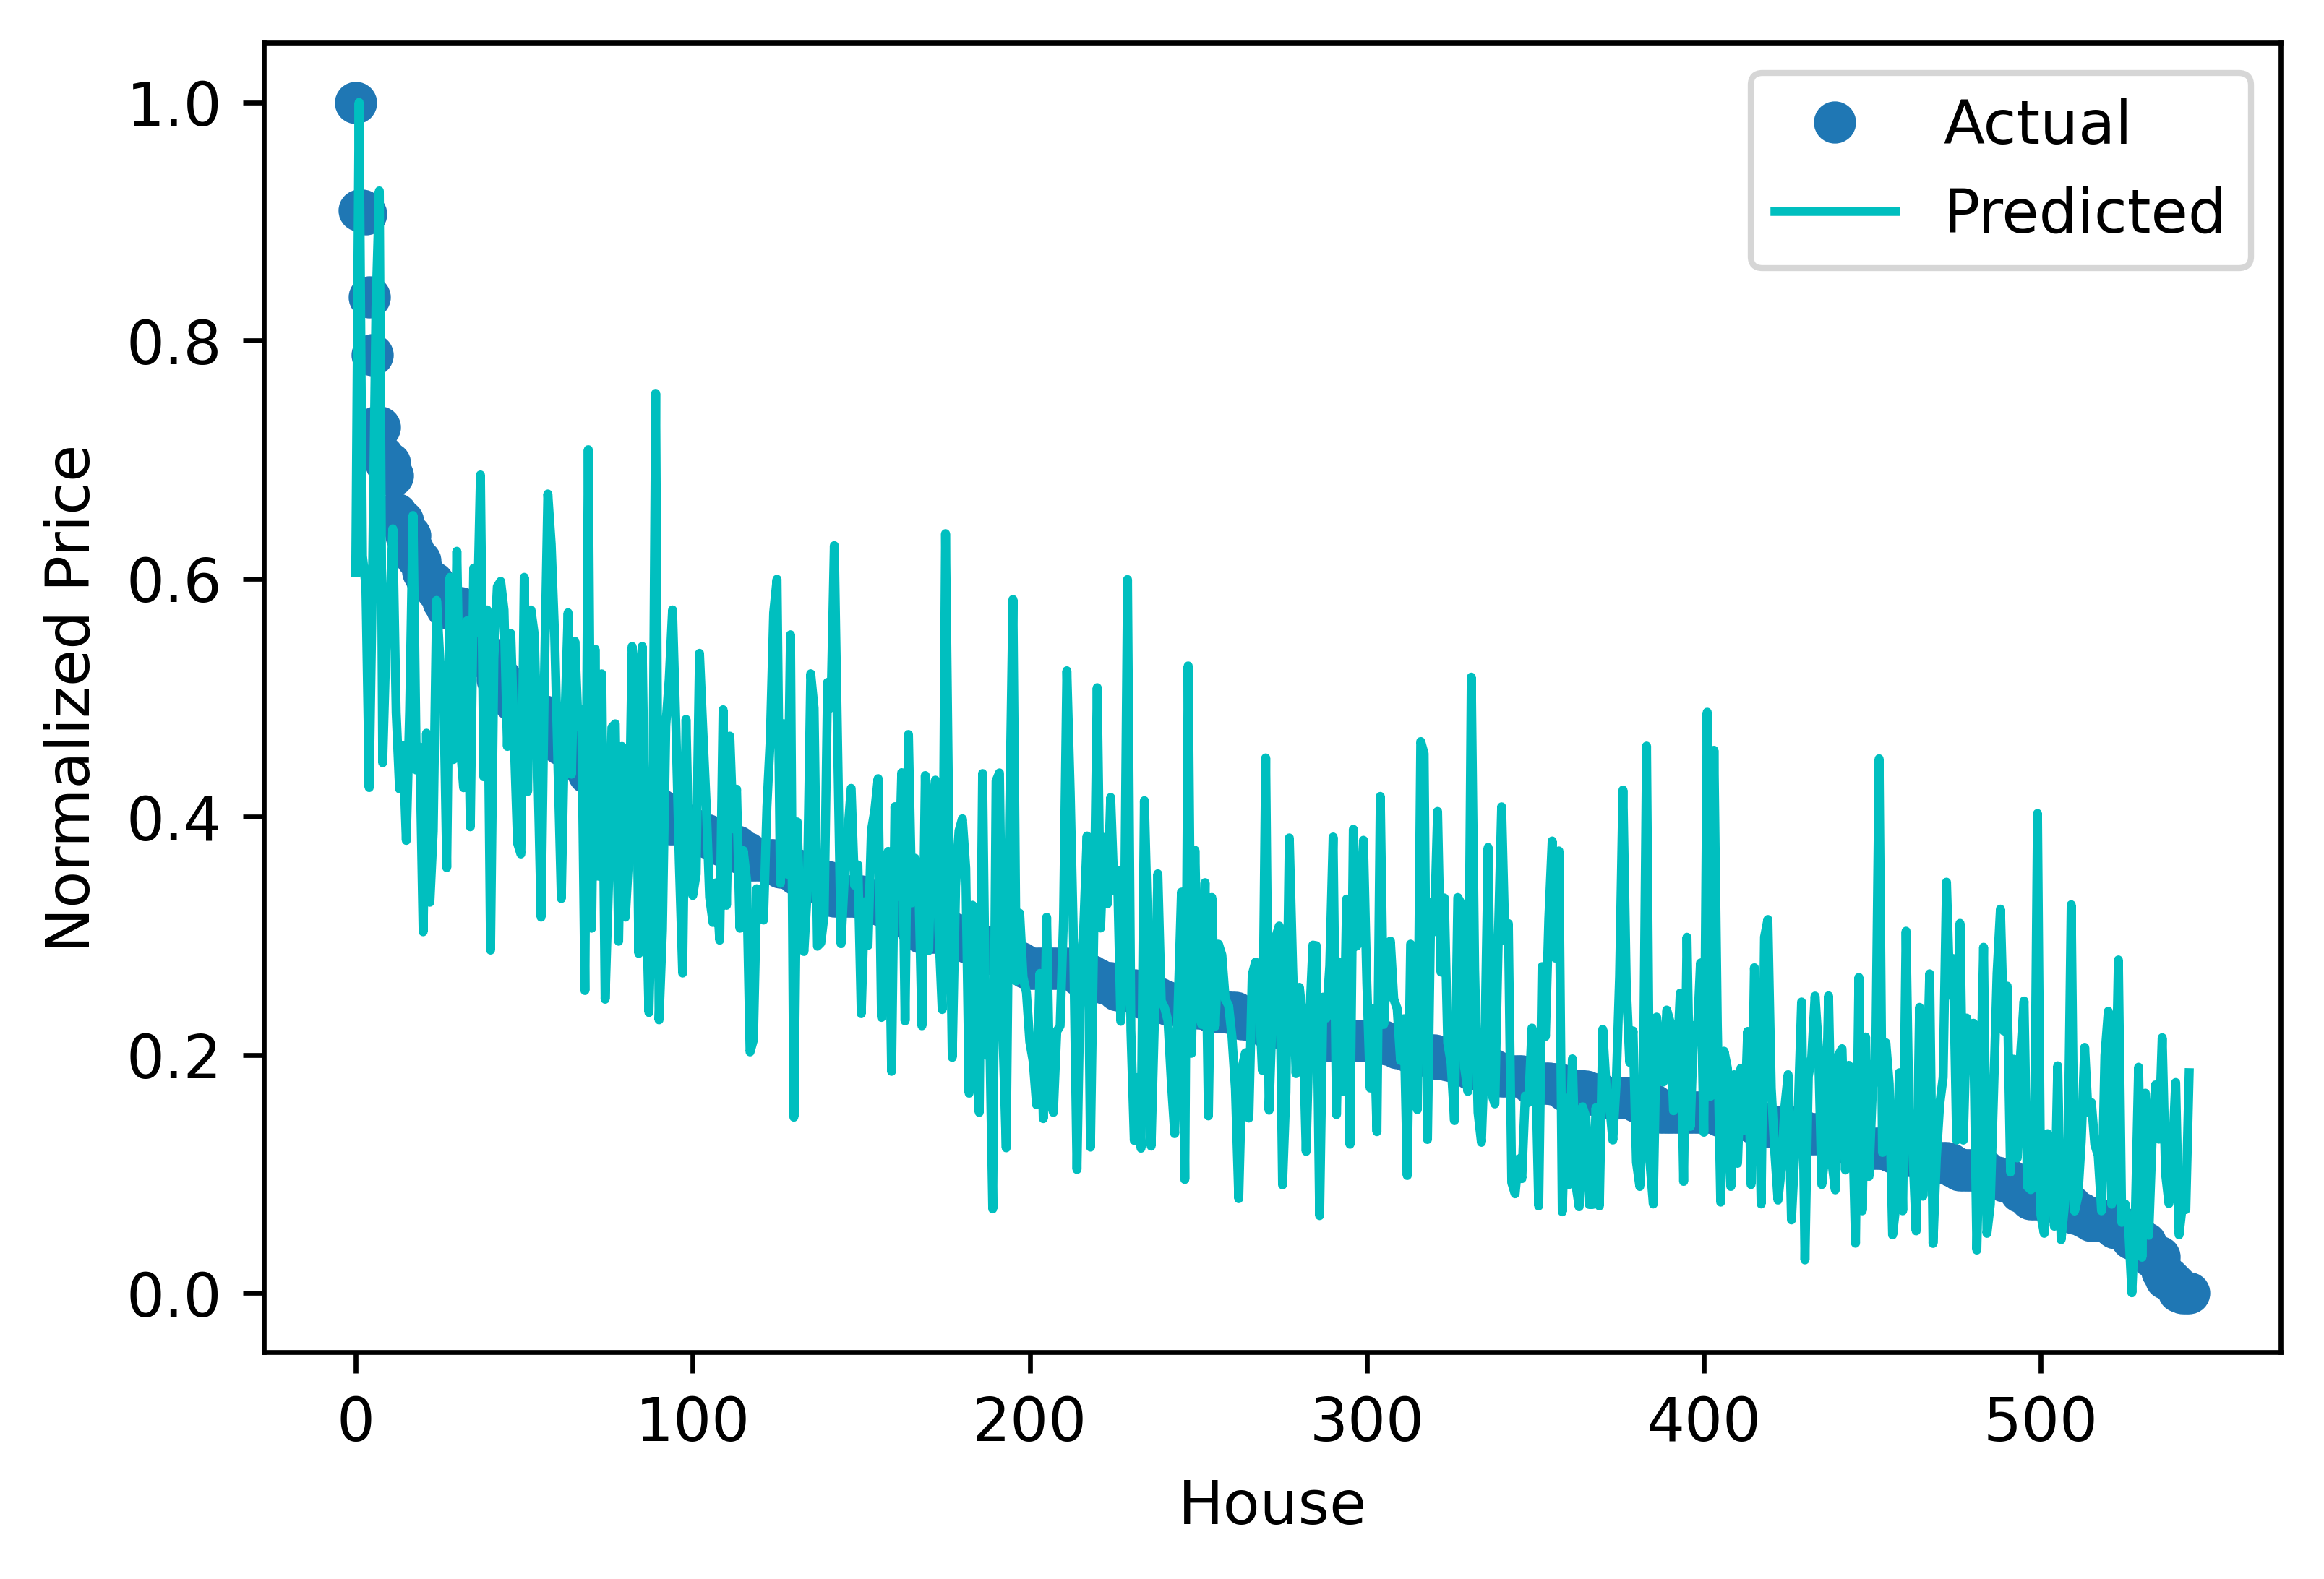

In [ ]:
t_p = seq_model(t_u_n)
t_p = torch.FloatTensor(scaler.fit_transform(t_p.detach().numpy()))
fig = plt.figure(dpi=600)
plt.xlabel("House")
plt.ylabel("Normalized Price")
plt.plot(t_price_n.numpy(), 'o')
plt.plot(t_p.detach().numpy(), '-c')
plt.legend(['Actual', 'Predicted'])